In [0]:
import numpy as np
import glob
import os
from PIL import Image as Pimage
import pickle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dense, LeakyReLU, Input, Activation, BatchNormalization, Reshape
from tensorflow.keras.models import Model
import zipfile
import shutil

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if os.path.exists("./data"):
  shutil.rmtree("./data")
zip_ref = zipfile.ZipFile("/content/drive/My Drive/decoder_dataset/data.zip", 'r')
zip_ref.extractall(".")
zip_ref.close()

In [0]:
data_img_list = glob.glob("./data/*.jpg")

In [26]:
len(data_img_list)

13176

In [0]:
data_plk_list = []
img_encode = {}
for img_path in data_img_list:
    #print(img_path[:-4])
    img_path_base = img_path.split('.')[1]
    with open( "./" +img_path_base + ".pkl", 'rb') as f:
        data = pickle.load(f)
        data_plk_list.append(data)
        img_encode[img_path] = data
        #print(data)

In [0]:
img_encode[data_img_list[0]]

In [0]:
ori_img_list = np.array(data_img_list)
ori_plk_list = np.array(data_plk_list)

In [0]:
shuffle_idx = np.arange(len(data_img_list))
np.random.seed(42)
np.random.shuffle(shuffle_idx)
shuffle_img_list = ori_img_list[shuffle_idx]
shuffle_plk_list = ori_plk_list[shuffle_idx]

In [0]:
def gen_train(train_path, batch_size):
    x,y = [], []
    cnt = 0
    while True:
        for img_path in train_path:
            img = keras.preprocessing.image.load_img(img_path, target_size=(64,64))
            x.append(img_encode[img_path])
            img_array = np.array(keras.preprocessing.image.img_to_array(img))/255.0
            #print(img_array)
            #plt.imshow(img_array)
            #print(type(img_array))
            #print(img_array)
            y.append(img_array)
            cnt += 1
            if cnt == batch_size:
                cnt = 0
                yield (np.array(x), np.array(y))
                x,y = [], []

In [0]:
gen = gen_train(shuffle_img_list[:6000], 2)

In [33]:
cnt = 0
for data in gen:
    cnt += 1
    print(data[0].shape, data[1].shape)
    if cnt >= 2:
        break

(2, 128) (2, 64, 64, 3)
(2, 128) (2, 64, 64, 3)


In [0]:
input = Input(shape=(128, ))
x = Dense(16384)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Reshape((4,4,1024))(x)
x = UpSampling2D()(x)
x = Conv2D(512, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(256, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(128, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(3, 3, padding='same')(x)
x = Activation("tanh")(x)
model = Model(input, x)

In [56]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             2113536   
_________________________________________________________________
batch_normalization_21 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 512)         4719

In [0]:
def r_loss(y_true, y_pred):
    return keras.backend.mean(keras.backend.square(y_true - y_pred), axis=[1,2,3])

In [0]:
model.compile(optimizer="rmsprop", loss=r_loss, metrics=['acc'])

In [0]:
gen = gen_train(shuffle_img_list[:12000], 16)

In [0]:
history =  model.fit_generator(gen, epochs=30, steps_per_epoch=12000//16)

In [54]:
len(history.history['loss'])

30

In [0]:
model.save("/content/drive/My Drive/decoder_dataset/decoder.h5")

In [0]:
test_x = img_encode[shuffle_img_list[0]].reshape((1 , 128) )

In [46]:
type(test_x)

numpy.ndarray

In [0]:
test_img = model.predict(test_x).reshape(64,64,3)

In [0]:
from matplotlib.pylab import plt

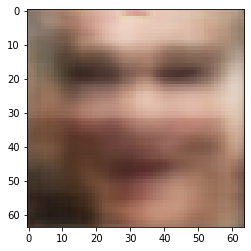

In [52]:
plt.imshow(test_img)

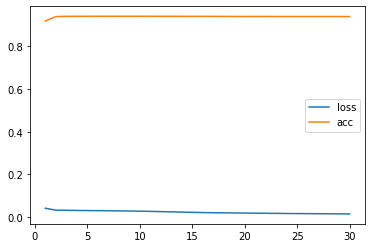

In [55]:
epochs = range(1, 30+1)
plt.figure()
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['acc'], label='acc')
plt.legend()
plt.show()